In [1]:
import espressomd
import espressomd.shapes
from espressomd import polymer
from espressomd.shapes import Cylinder, Wall, Union
from espressomd.interactions import FeneBond
from espressomd.interactions import AngleCosine
import numpy as np
import matplotlib.pyplot as plt
from espressomd.observables import ParticlePositions
from espressomd.observables import ComPosition
from espressomd.accumulators import Correlator
from espressomd.observables import DensityProfile
from pprint import pprint
from threading import Thread
#from espressomd import visualization
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

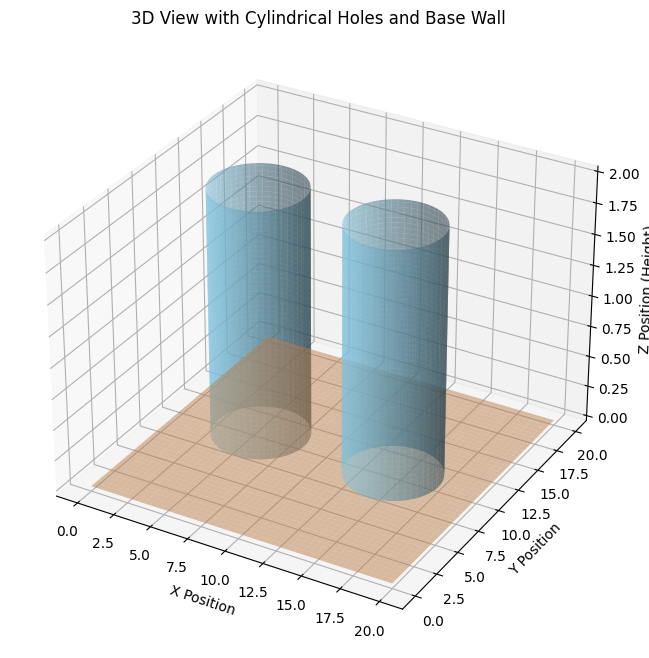

In [2]:
sys_boxl = [20., 20., 100.]
sys_dt_start = 0.0005
sys_temperature_start = 0.2
sys_gamma = 1.0

system = espressomd.System(box_l=sys_boxl)
system.time_step = sys_dt_start
system.thermostat.set_langevin(kT=sys_temperature_start, gamma=sys_gamma, seed=40)

# cylinder 1
cylinder1 = Cylinder(center=[5.5, 10, 1], axis=[0, 0, 1], radius=3, length=2, direction=1, open=True)
# cylinder 2
cylinder2 = Cylinder(center=[14.5, 10, 1], axis=[0, 0, 1], radius=3, length=2, direction=1, open=True)
# single impenetrable wall underneath the cylinders at z=0
base_wall = Wall(normal=[0, 0, 1], dist=0)

union_shape = Union()
union_shape.add(cylinder1)
union_shape.add(cylinder2)
union_shape.add(base_wall)

# add shape constraint
system.constraints.add(shape=union_shape, particle_type=0, penetrable=False)

# side view visualize
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
cylinder_heights = [2, 2] 
cylinder_centers = [(5.5, 10, 1), (14.5, 10, 1)]
cylinder_radii = [3, 3] 
def plot_cylinder(center, radius, height, color='skyblue'):
    z = np.linspace(0, height, 100) + center[2] - height / 2  
    theta = np.linspace(0, 2 * np.pi, 100)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius * np.cos(theta_grid) + center[0]
    y_grid = radius * np.sin(theta_grid) + center[1]
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=0.6)
for center, height, radius in zip(cylinder_centers, cylinder_heights, cylinder_radii):
    plot_cylinder(center, radius, height)
x = np.linspace(0, 20, 400)
y = np.linspace(0, 20, 400)
x, y = np.meshgrid(x, y)
z = np.full_like(x, 0)  
ax.plot_surface(x, y, z, color='sandybrown', alpha=0.5)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position (Height)')
ax.set_title('3D View with Cylindrical Holes and Base Wall')

plt.show()

In [3]:
#initialize polymer
N_MONOMER = 150 
BOND_L = 0.3 
n_polymers = 1

z_pos = np.arange(30+0.5,N_MONOMER+1+0.5,BOND_L)
x_pos = sys_boxl[0]*0.5*np.ones(N_MONOMER)
y_pos = sys_boxl[1]*0.5*np.ones(N_MONOMER)

for j in range(n_polymers):
    for i in range(N_MONOMER):
        system.part.add(type=j+1,pos=[x_pos[i],y_pos[i], z_pos[i]+j*N_MONOMER*BOND_L],q=-1.)

In [4]:
wca_epsilon = 1. 
wca_sigma = 0.3 

system.non_bonded_inter[0,1].wca.set_params(epsilon=20, #*20
                                           sigma=0.2) #-0.2
system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                           sigma=wca_sigma)

# elastic bond params
fene_k = 10.
fene_drmax = 2.
fene_r0 = 0.0

# fene bonds
fene = FeneBond(k=fene_k, d_r_max=fene_drmax, r_0=fene_r0)
system.bonded_inter.add(fene)
previous_particle = None
for particle in system.part:
    #print("Position:", particle.pos)
    if previous_particle is not None and particle != previous_particle:
        particle.add_bond((fene, previous_particle))
    previous_particle = particle

In [5]:
#warming up
system.cell_system.skin = 0.3
warm_steps = 5 # control the force release rate. smaller, faster. Break bond: relase too fast. 
warm_n_time = 2000
min_dist = 10
wca_cap = 1.0
i = 0
while i<warm_n_time:
    system.force_cap = wca_cap
    system.integrator.run(warm_steps)

    wca_cap += 0.5 
    i+=1
    if i%200==0:
        print(i)

    if i==600:
        wca_sigma = 0.4 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

        angle_cosine = AngleCosine(bend=0.48, phi0=np.pi) 
        system.bonded_inter.add(angle_cosine)

        #for j1 in range(n_polymers):
            #for i1 in range(N_MONOMER-2):
                #system.part[int(N_MONOMER*j1+i1+1)].add_bond((angle_cosine, int(N_MONOMER*j1+i1), int(N_MONOMER*j1+i1+2)))

    if i==800:
        wca_sigma = 0.5 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)
    if i==1000:
        wca_sigma = 0.6 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

    if i==1200:
        wca_sigma = 0.7 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

    if i==1400:
        wca_sigma = 0.8 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

    if i==1600:
        wca_sigma = 0.9 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)
        
    if i==1800:
        wca_sigma = 1.0 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)
        
system.force_cap = 0
print('Warming done!')

200
400
600
800
1000
1200
1400
1600
1800
2000
Warming done!


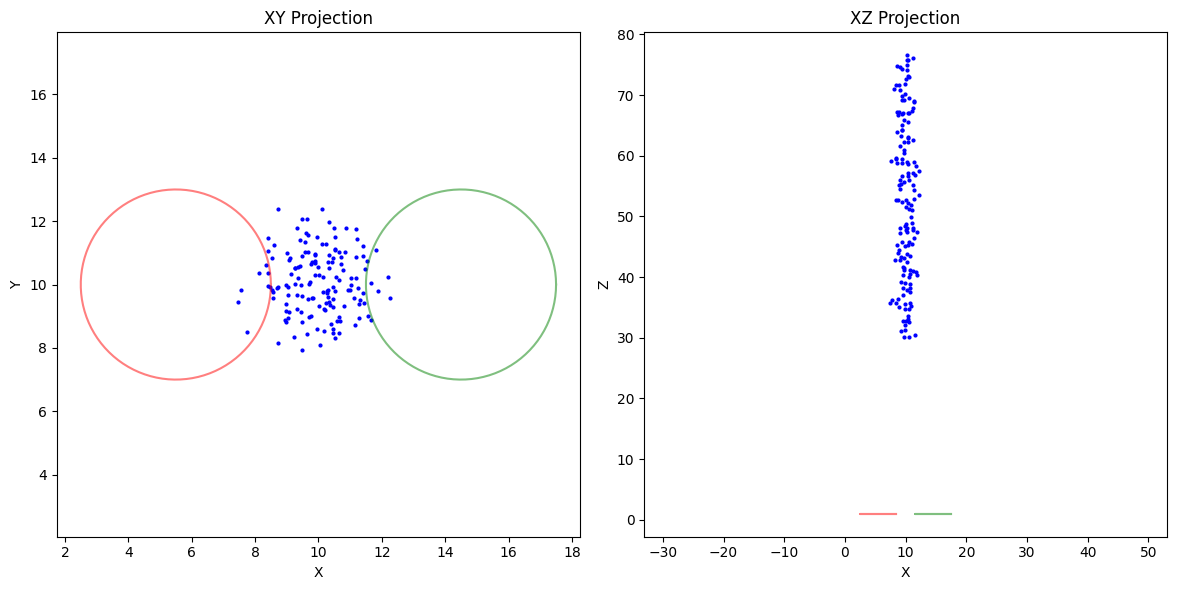

Iteration 0


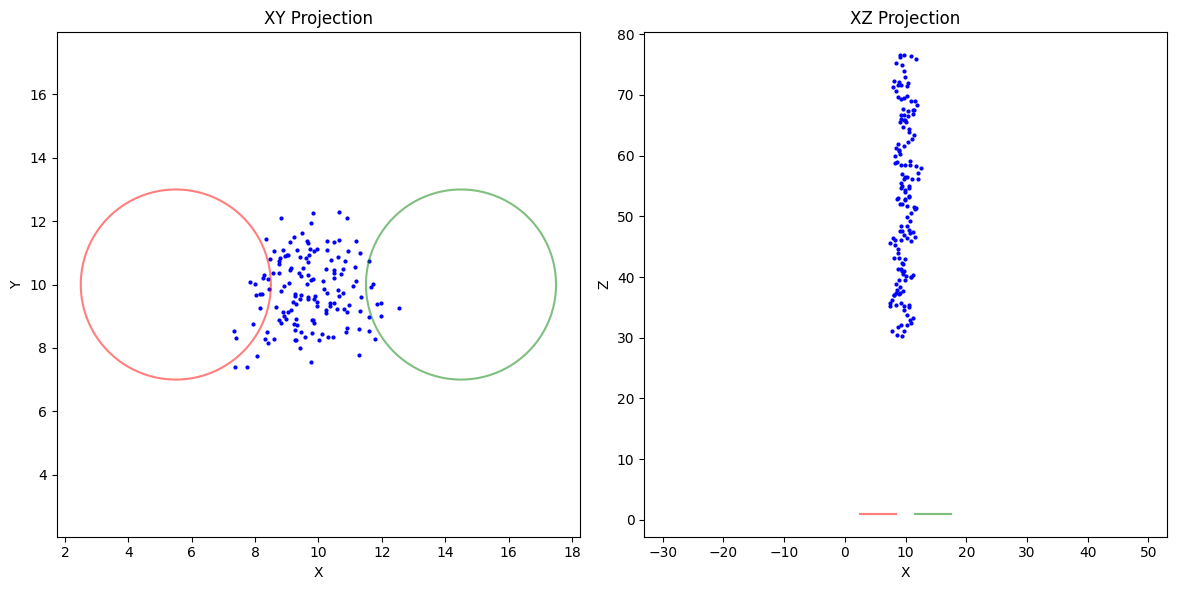

Iteration 50


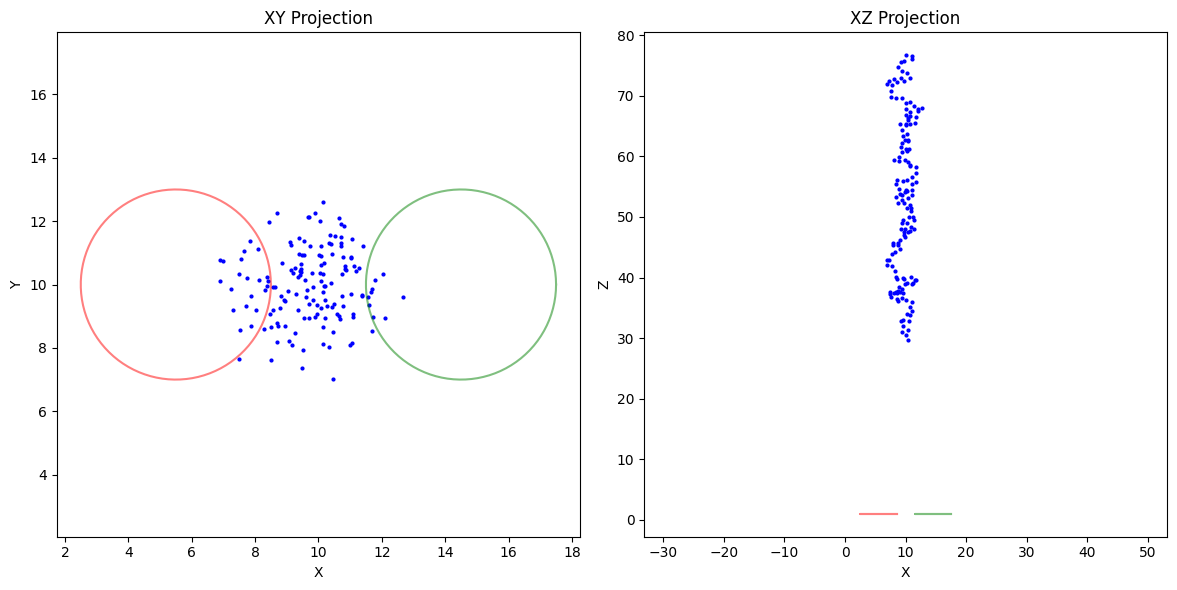

Iteration 100


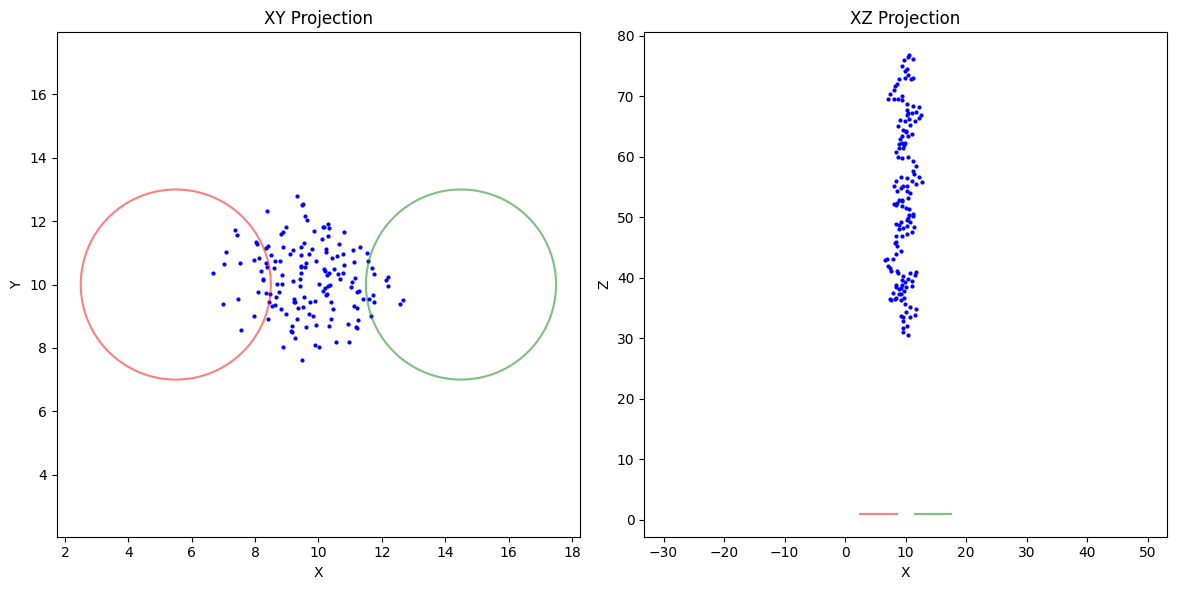

Iteration 150


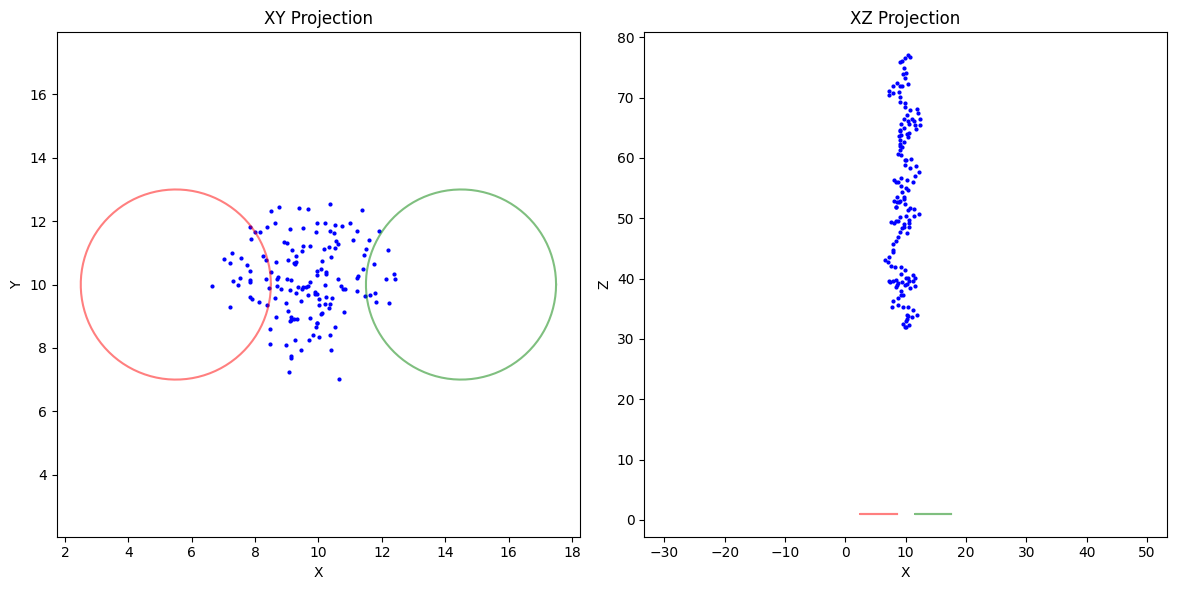

Iteration 200


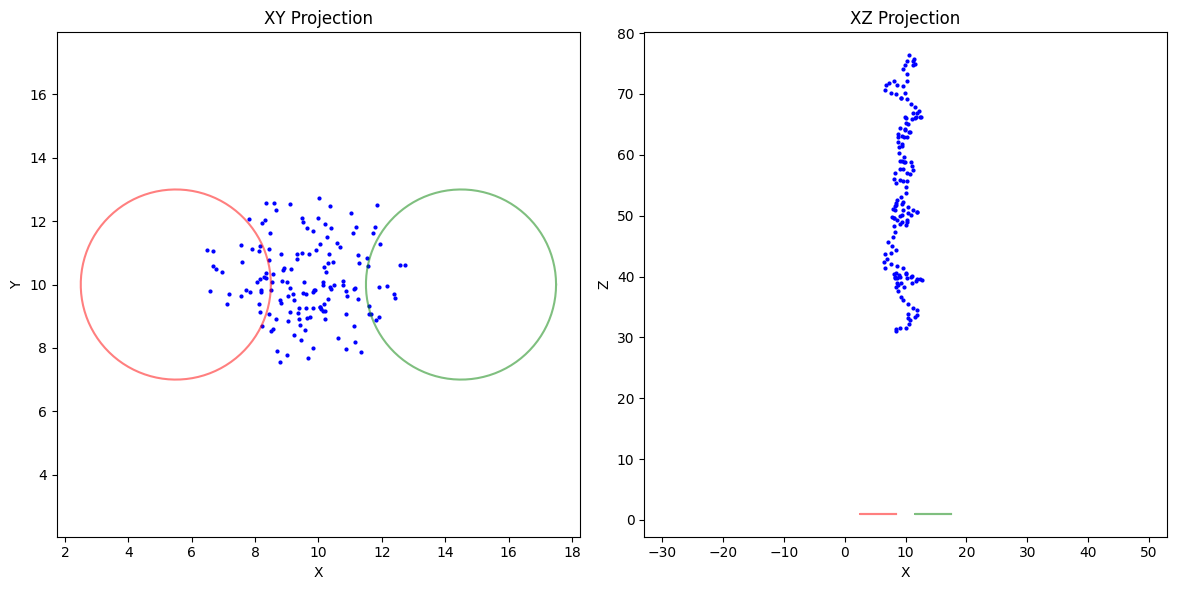

Iteration 250


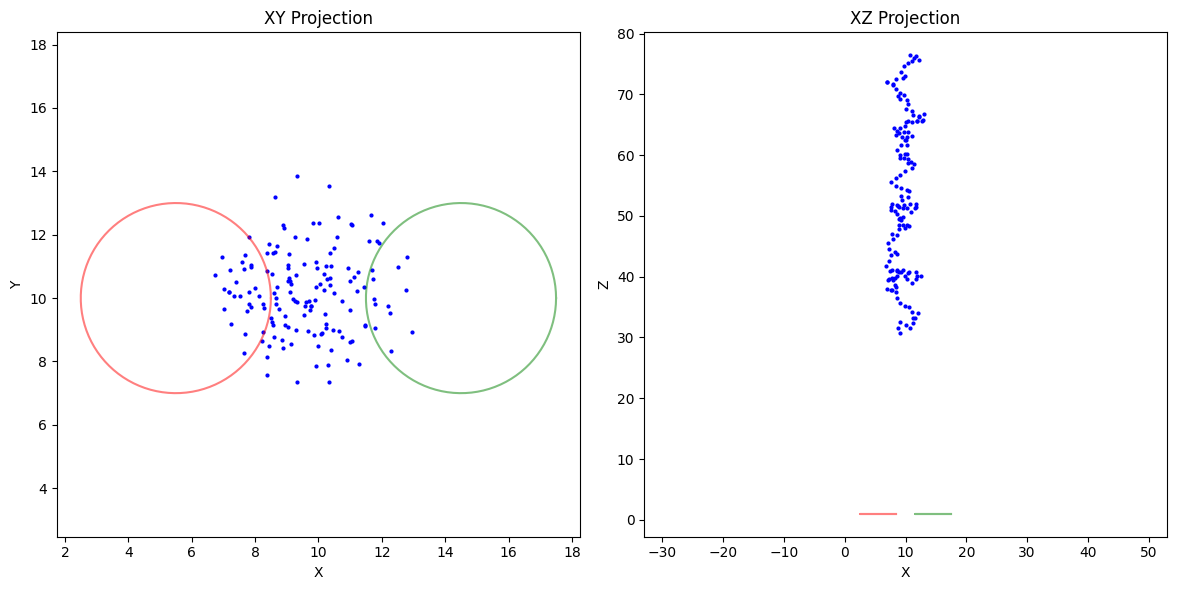

Iteration 300


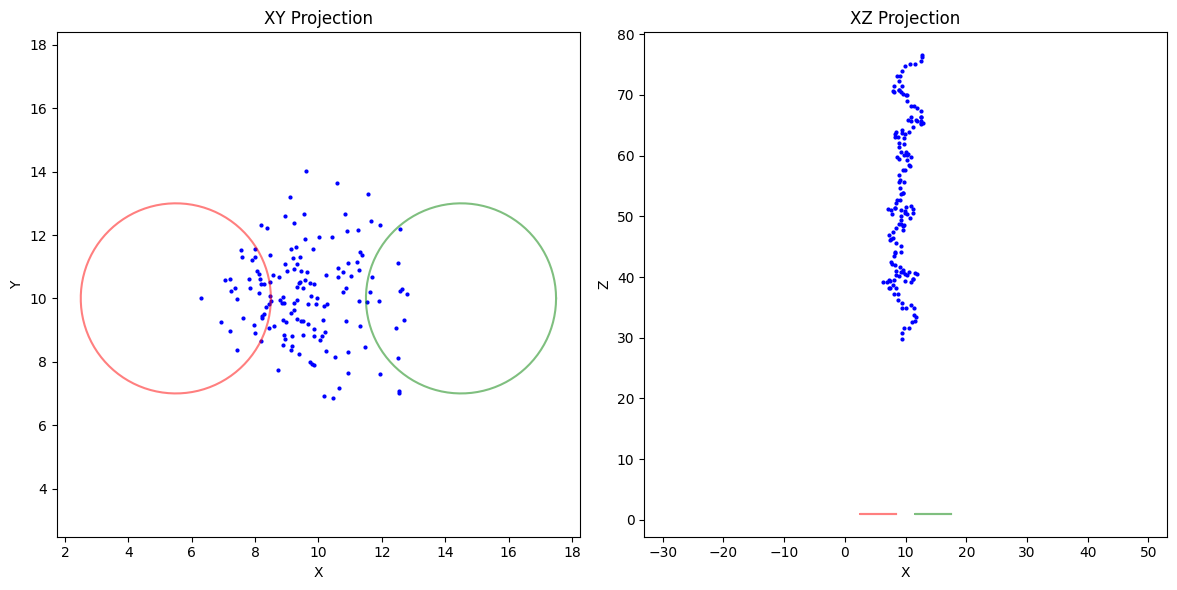

Iteration 350


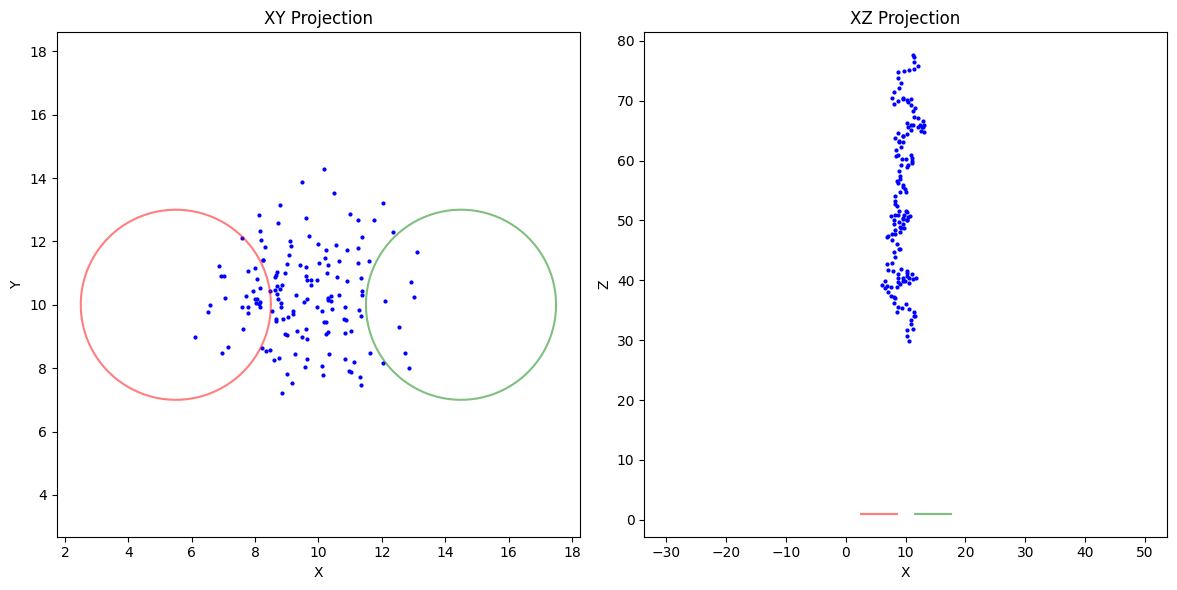

Iteration 400


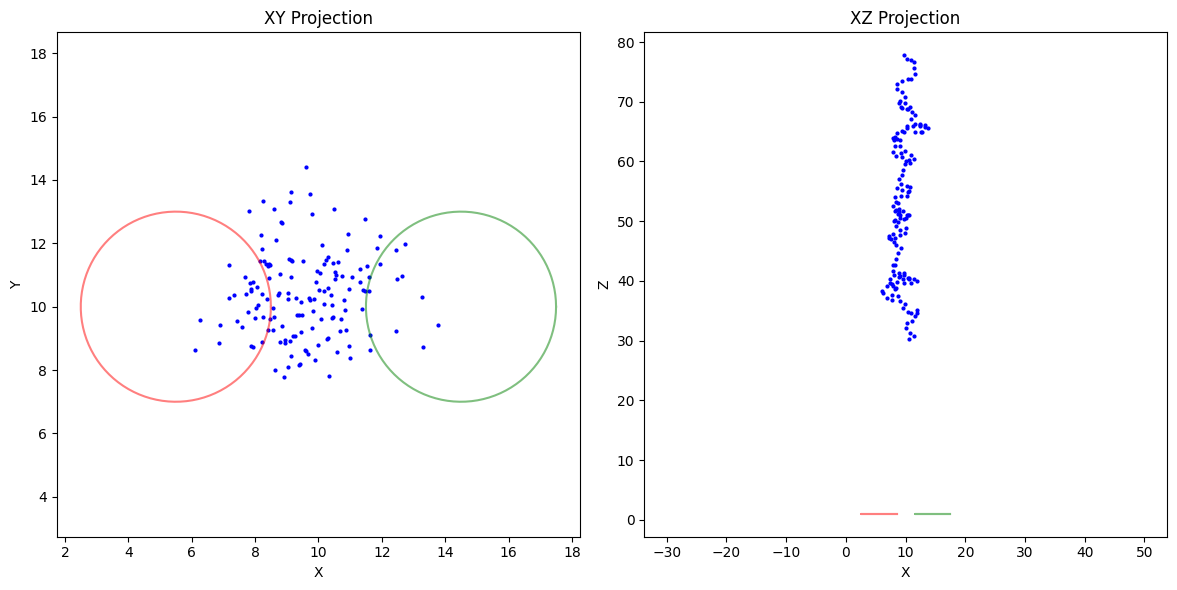

Iteration 450


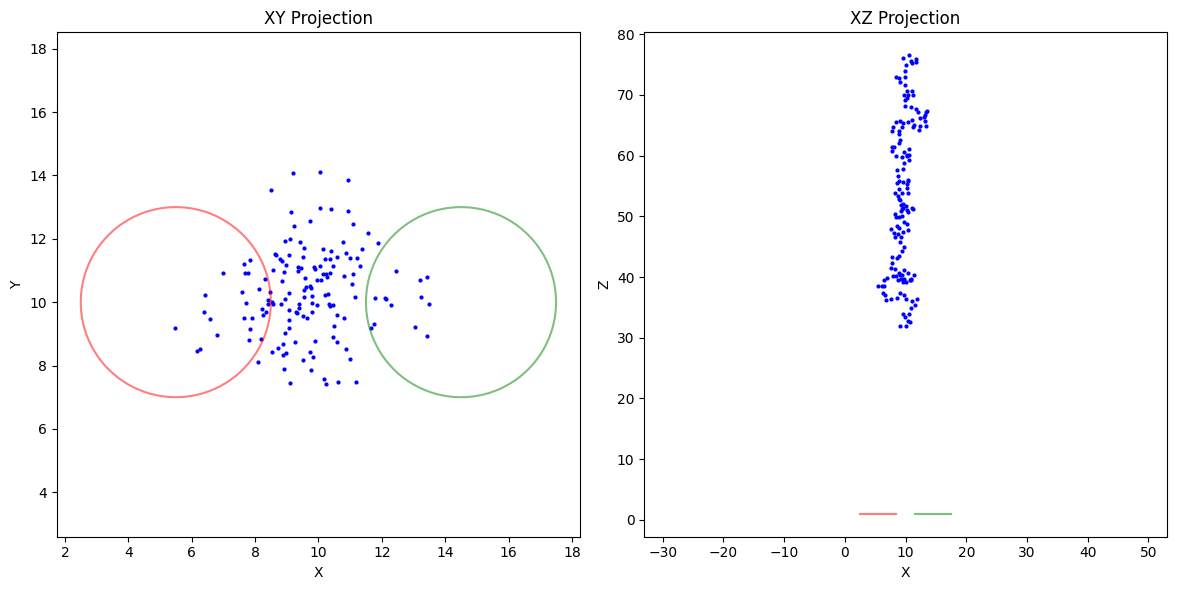

Iteration 500


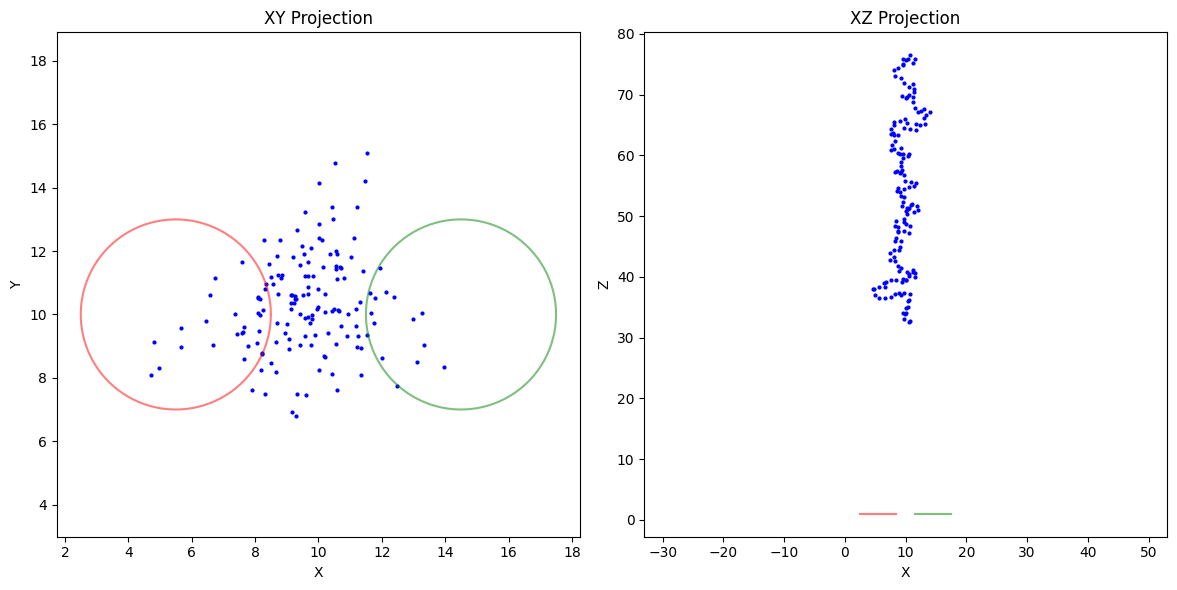

Iteration 550


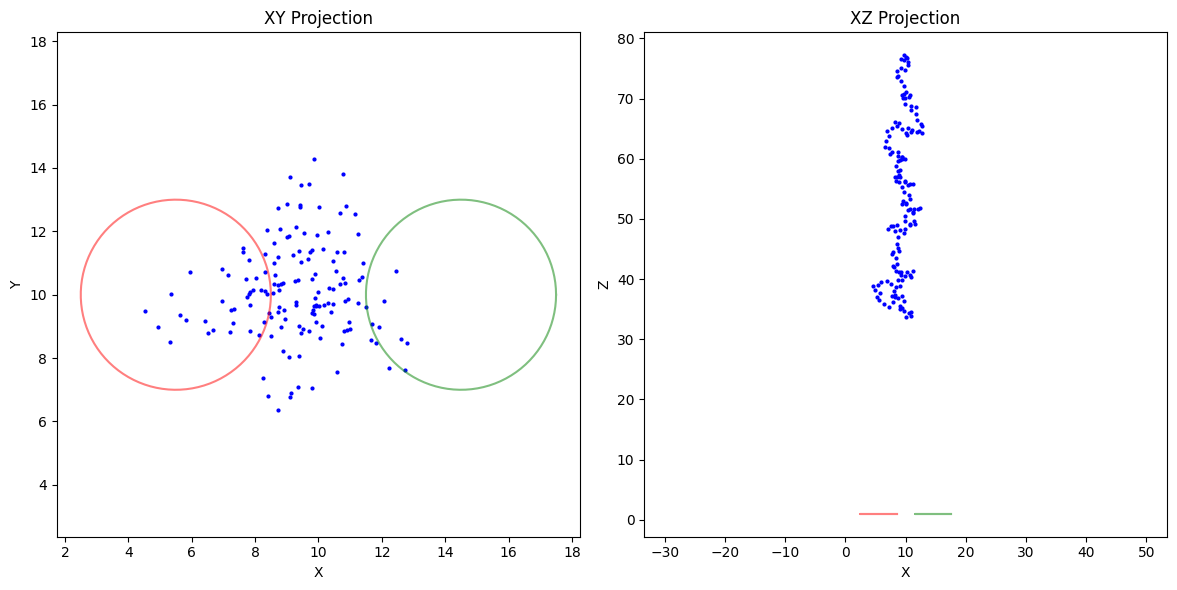

Iteration 600


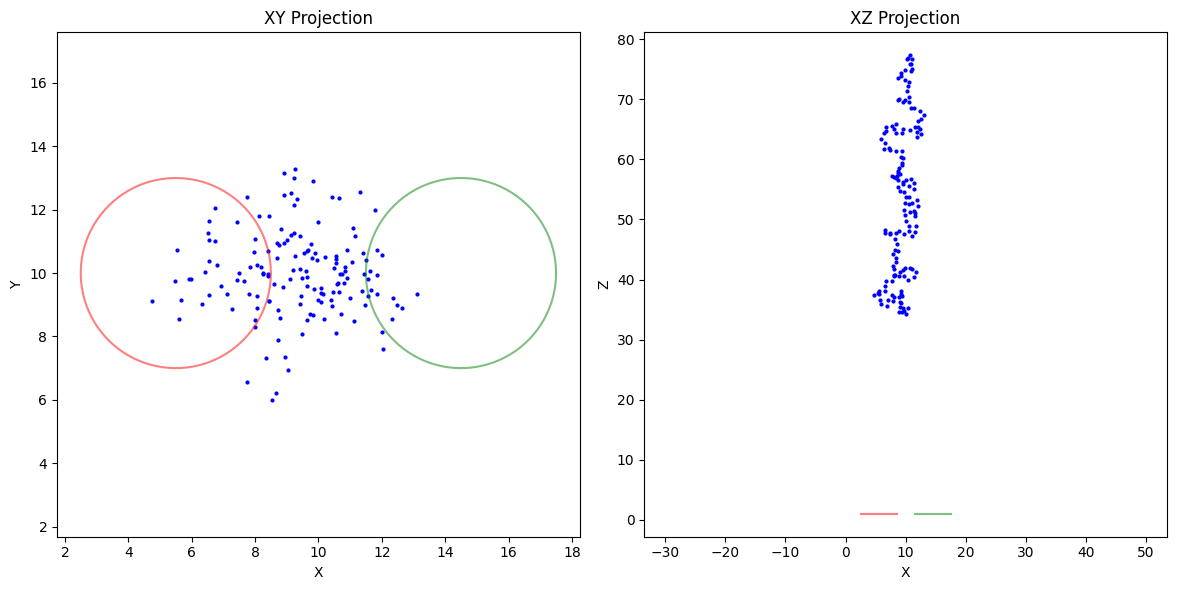

Iteration 650


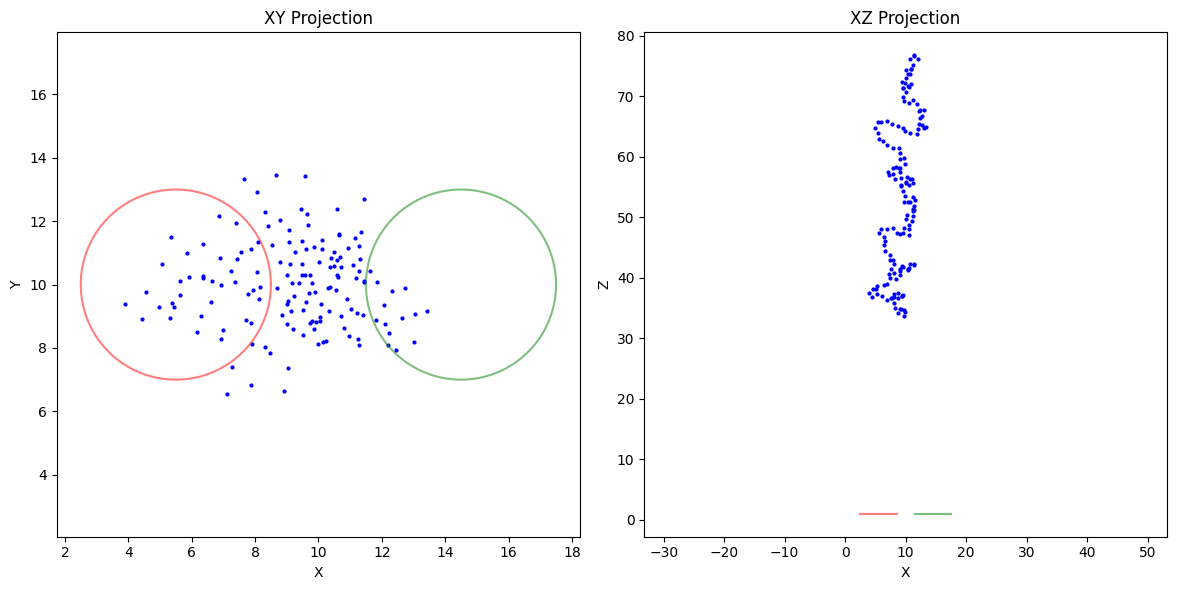

Iteration 700


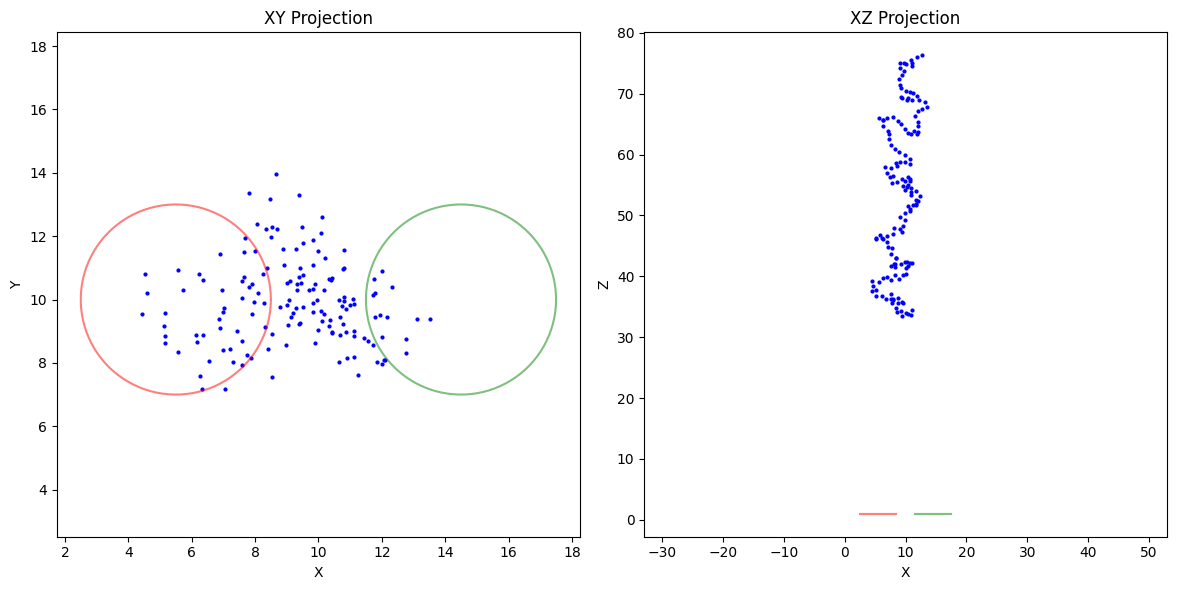

Iteration 750


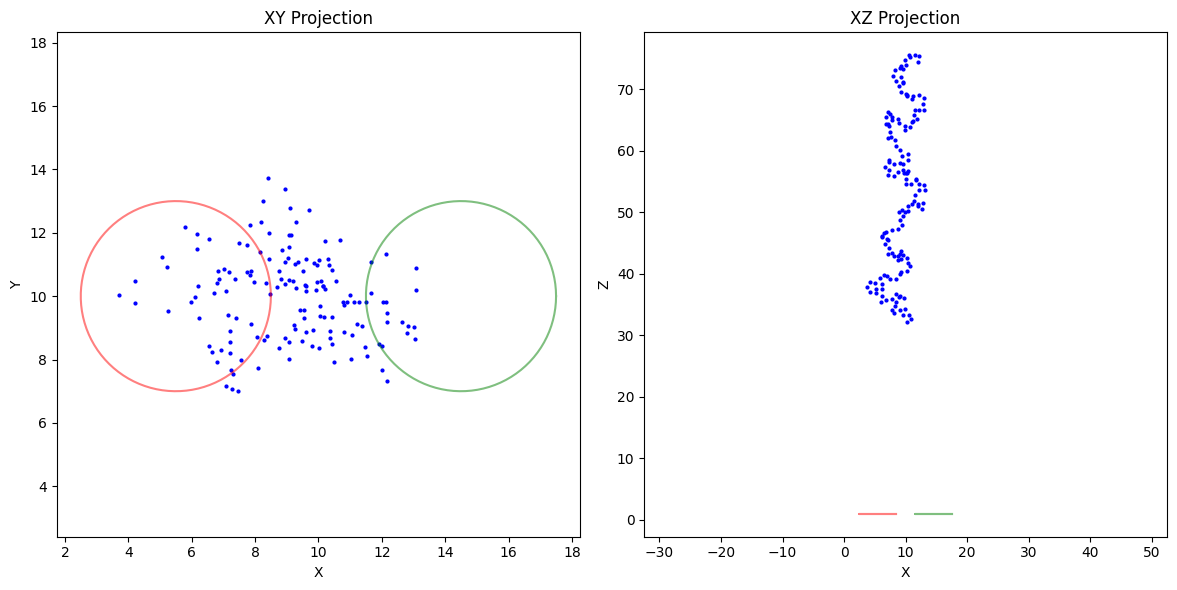

Iteration 800


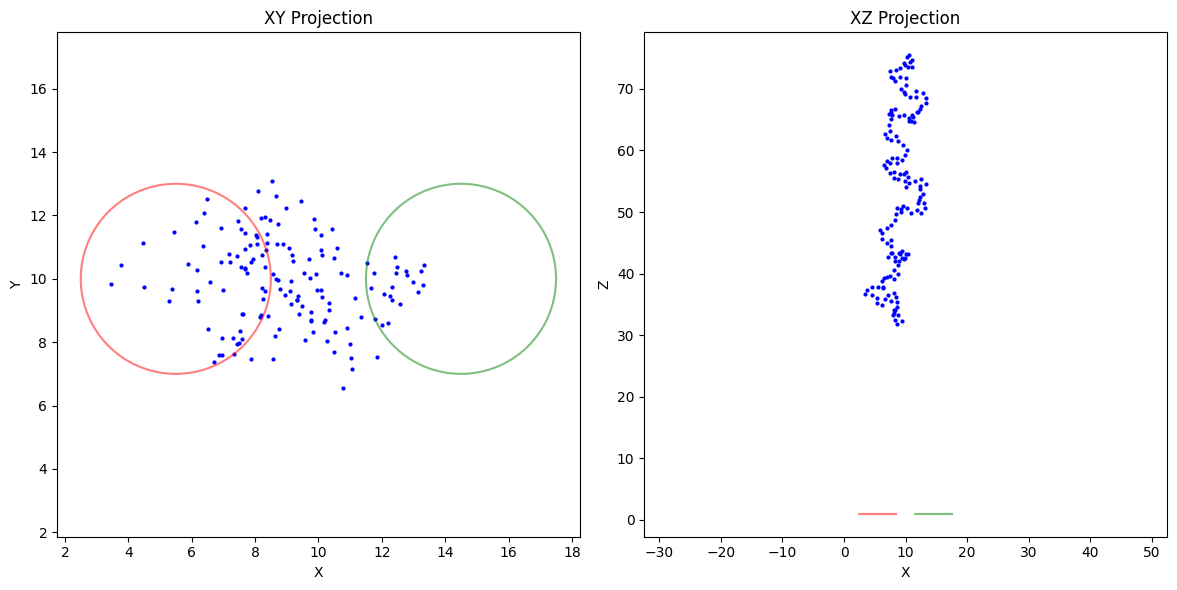

Iteration 850


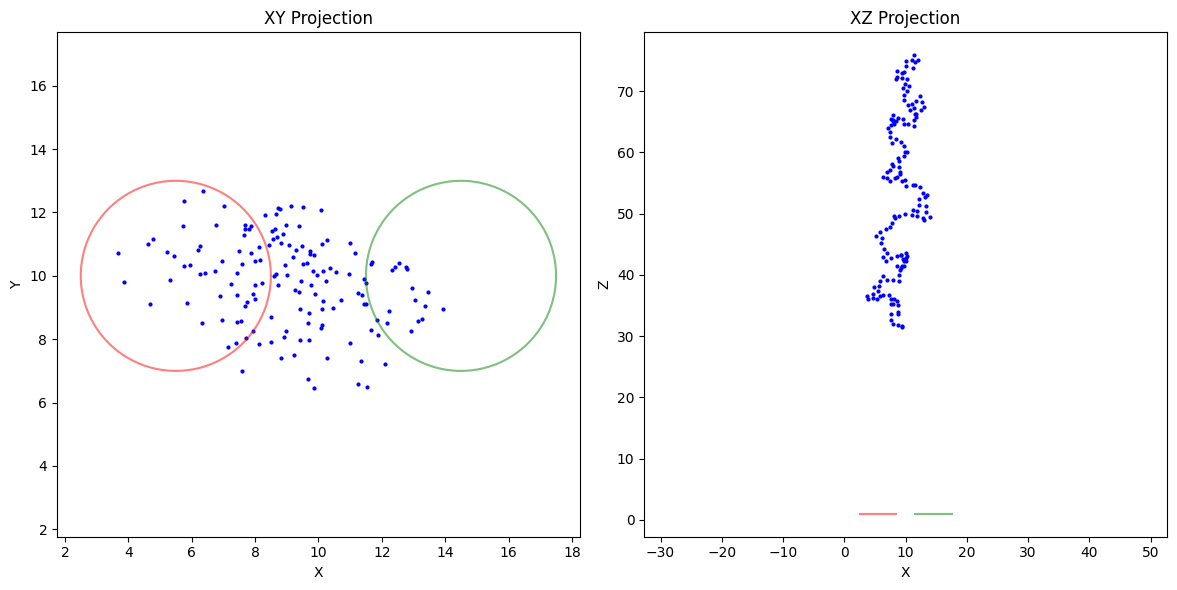

Iteration 900


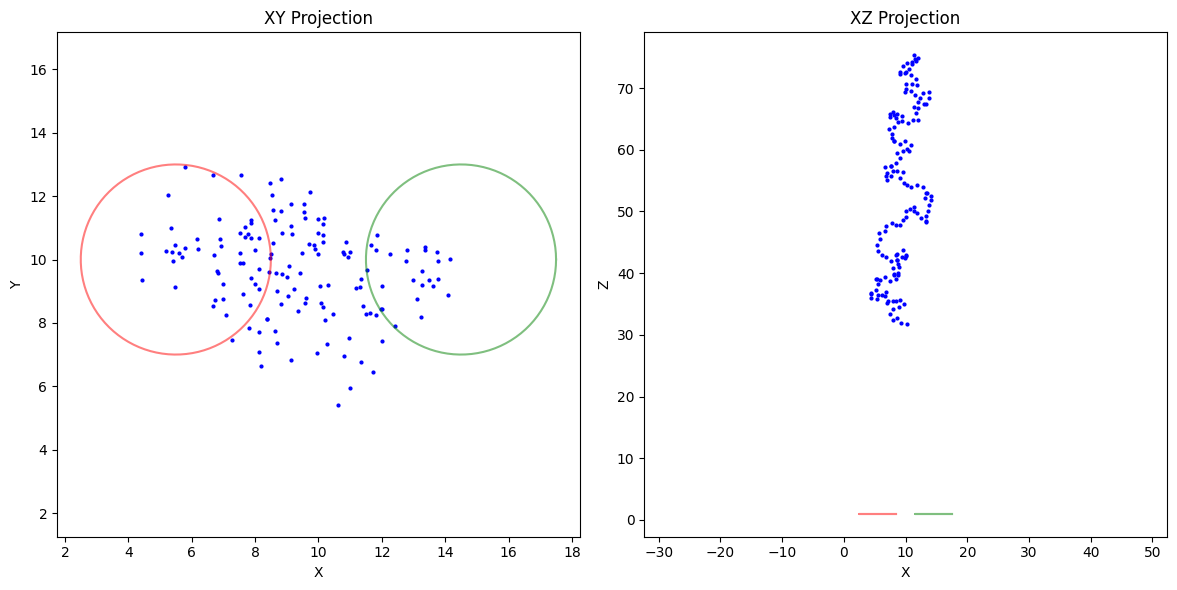

Iteration 950


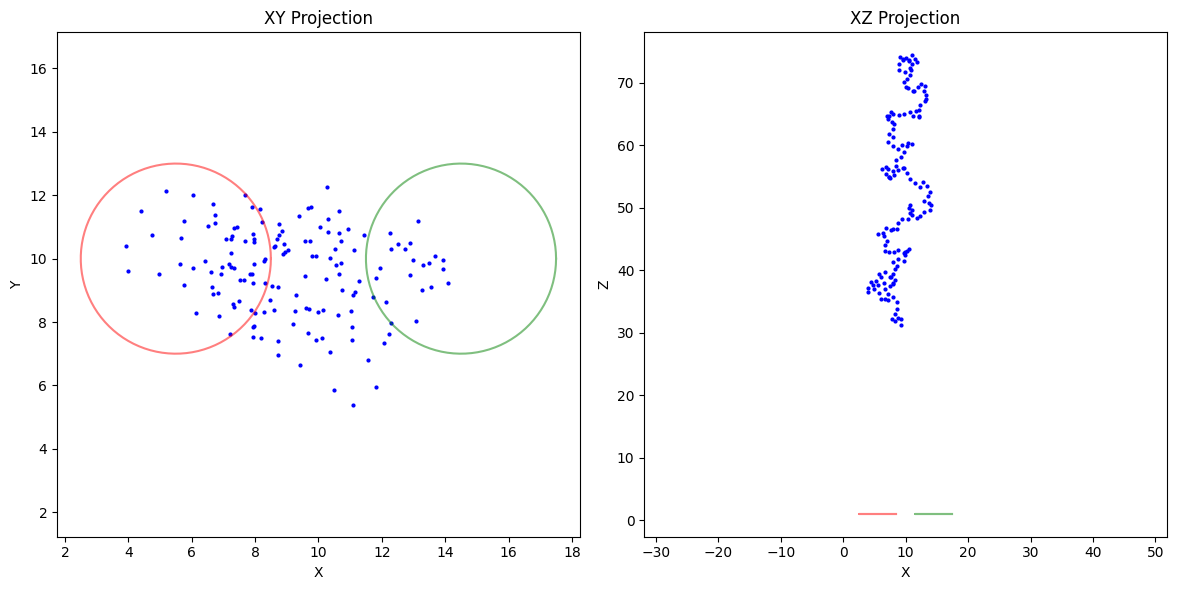

Iteration 1000


In [6]:
intstep = 2000
skip = 50

sys_dt = 0.0005
system.time_step = sys_dt
sys_temperature = 0.2
system.thermostat.set_langevin(kT = sys_temperature,gamma = sys_gamma, seed=20)

radius = 3.0
center = [5.5, 10.0, 1.0]
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = center[0] + radius * np.cos(theta)
y_circle = center[1] + radius * np.sin(theta)
z_circle = np.full_like(x_circle, center[2])

center2 = [14.5, 10.0, 1.0]
x_circle2 = center2[0] + radius * np.cos(theta)
y_circle2 = center2[1] + radius * np.sin(theta)
z_circle2 = np.full_like(x_circle2, center2[2])

def main():
    for i in range(intstep):
        system.integrator.run(200)
        if i % skip == 0:
            positions = np.array([p.pos for p in system.part])
            fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

            # XY
            ax_xy.plot(positions[:, 0], positions[:, 1], 'bo', markersize=2)
            ax_xy.plot(x_circle, y_circle, 'r-', alpha=0.5) 
            ax_xy.plot(x_circle2, y_circle2, 'g-', alpha=0.5) 
            ax_xy.set_xlabel('X')
            ax_xy.set_ylabel('Y')
            ax_xy.set_title('XY Projection')
            ax_xy.axis('equal')

            # XZ 
            ax_xz.plot(positions[:, 0], positions[:, 2], 'bo', markersize=2)
            ax_xz.plot(x_circle, z_circle, 'r-', alpha=0.5)  
            ax_xz.plot(x_circle2, z_circle2, 'g-', alpha=0.5)  
            ax_xz.set_xlabel('X')
            ax_xz.set_ylabel('Z')
            ax_xz.set_title('XZ Projection')
            ax_xz.axis('equal')

            plt.tight_layout()
            plt.show()
            print(f"Iteration {i}")

        if i == 1000:
            electric_field_strength = [0, 0, 1]
            linear_electric_potential = espressomd.constraints.LinearElectricPotential(E=electric_field_strength, phi=0)
            system.constraints.add(linear_electric_potential)

# Rmk: initialize separate thread
system.time = 0
t = Thread(target=main)
t.start()